## Lucid: Cluster Predictor

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
import xgboost as xgb
from primo.model import PrimoRegressor

sns.set_style("ticks")
font = {
    "font.family": "Roboto",
    "font.size": 12,
}
sns.set_style(font)
paper_rc = {
    "lines.linewidth": 3,
    "lines.markersize": 10,
}
sns.set_context("paper", font_scale=1.8, rc=paper_rc)
current_palette = sns.color_palette()

pd.set_option("display.max_columns", None)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)


seed = 123
set_seed(seed)

cluster_list = ["Venus", "Saturn", "Philly"]
cluster = cluster_list[0]
df = pd.read_csv(
    f"../data/{cluster}/cluster_throughput.csv",
    parse_dates=["time"],
    index_col="time",
    usecols=["time", "submit_gpu_job", "submit_gpu_num"],
)
result = pd.DataFrame()

In [3]:
def soft_avg(data, t):
    avg = 0.5 * data.transform(lambda x: x.shift(t))
    avg += 0.25 * (data.transform(lambda x: x.shift(t + 1)) + data.transform(lambda x: x.shift(t - 1)))
    return avg


def rolling_data(df, item):
    if item == "submit_gpu_job":
        short = "njob"
    elif item == "submit_gpu_num":
        short = "ngpu"
    else:
        raise ValueError

    df[f"shift_1h_{short}"] = df[item].transform(lambda x: x.shift(6))  # 1 Hour Ago
    df[f"shift_3h_{short}"] = df[item].transform(lambda x: x.shift(18))  # 3 Hour Ago
    df[f"shift_1d_{short}"] = df[item].transform(lambda x: x.shift(144))  # 1 Day Ago

    df[f"soft_1h_{short}"] = soft_avg(df[item], 6)  # Soft 1 Hour Ago
    df[f"soft_3h_{short}"] = soft_avg(df[item], 18)  # Soft 3 Hour Ago
    df[f"soft_1d_{short}"] = soft_avg(df[item], 144)  # Soft 1 Day Ago

    df[f"roll_mean_1h_{short}"] = df[item].transform(lambda x: x.shift(6).rolling(6).mean())  # 1 Hour Ago
    df[f"roll_median_1h_{short}"] = df[item].transform(lambda x: x.shift(6).rolling(6).median())  # 1 Hour Ago
    df[f"roll_std_1h_{short}"] = df[item].transform(lambda x: x.shift(6).rolling(6).std())  # 1 Hour Ago

    return df


def feature_engineering(df):
    data = df.reset_index()

    """Time Features"""
    time_features = ["month", "day", "hour", "minute", "dayofweek", "dayofyear"]
    for tf in time_features:
        data[tf] = getattr(data["time"].dt, tf).astype(np.int16)
    data["week"] = data["time"].dt.isocalendar().week.astype(np.int16)  # weekofyear

    """Job Num & GPU Num Rolling"""
    data = rolling_data(data, "submit_gpu_job")
    data = rolling_data(data, "submit_gpu_num")

    return data


def plot_predict(pred, test, item, cluster, ymax=100, save=False):
    fig, ax = plt.subplots(figsize=(8, 3))
    x = np.arange(len(test))

    if "job" in item:
        str_y = "Job Submission"  # per 10 minutes"
    elif "num" in item:
        str_y = "GPU Submission"  # per 10 minutes"
    else:
        raise ValueError

    if cluster == "Philly":
        str_month = "November"
    else:
        str_month = "September"

    ax.plot(x, test[item].values, linestyle="--", alpha=0.9, label="Real", linewidth=2)
    ax.plot(x, pred, linestyle="-", alpha=0.9, label="Prediction", linewidth=2)
    ax.set_xlabel(f"Date in {str_month} ({cluster})")
    ax.set_ylabel(str_y)

    tick_interval = 2 * 144  # Two days
    ax.set_xticks(x[::tick_interval])
    ax.set_xticklabels(test["time"].dt.day[::tick_interval])
    ax.set_xlim(0, len(test) + 1)
    ax.set_ylim(0, ymax)
    ax.grid(axis="y", linestyle=":")
    ax.legend()
    sns.despine()

    if save:
        fig.savefig(f"./{cluster}_throughput_{str_y}.pdf", bbox_inches="tight")


data = feature_engineering(df)

if cluster == "Philly":
    month = 11
else:
    month = 9

train = data[data["month"] < month]
test = data[data["month"] == month]

train_data = train.iloc[:, 3:]
test_data = test.iloc[:, 3:]

train_job_label = train[["submit_gpu_job"]]
train_gpu_label = train[["submit_gpu_num"]]
test_job_label = test[["submit_gpu_job"]]
test_gpu_label = test[["submit_gpu_num"]]

train_data.fillna(value=0, inplace=True)
test_data.fillna(value=0, inplace=True)

# Plot
ymax_job = {"Saturn": 220, "Venus": 50, "Philly": 100, "Uranus": 100, "Earth": 100}
ymax_gpu = {"Saturn": 1200, "Venus": 500, "Philly": 150, "Uranus": 300, "Earth": 200}

### Interpretable Model: Primo(EBM)

In [ ]:
"""Job #"""
config = {"learning_rate": 0.1, "interactions": 10}
ebm = PrimoRegressor(model="PrAM", model_config=config, hpo=None)
ebm.fit(train_data, train_job_label)
pred = ebm.predict(test_data)

mae_score = metrics.mean_absolute_error(test_job_label, pred)
r2_score = metrics.r2_score(test_job_label, pred)
result.at["ebm_job_mae", cluster] = mae_score
print(f"mae_score: {mae_score:.2f}, r2_score: {r2_score:.4f}")

#pred_df.to_csv(f"./{cluster}_throughput_pred.csv", index=False)

Jun 05 17:48:53 | Training with given model configuration. Model tuning is disabled.
Jun 05 17:48:53 | Using `PrAMRegressor` model for training.
Jun 05 17:48:53 | EBM lib loading.
Jun 05 17:48:53 | Finding library for Linux, x86_64, bitsize=64, debug=False
Jun 05 17:48:53 | Loading EBM library /opt/conda/envs/lucid/lib/python3.9/site-packages/interpret/utils/../root/bld/lib/libebm_linux_x64.so
Jun 05 17:48:53 | Creating native dataset
Jun 05 17:48:56 | eval_terms
Jun 05 17:48:56 | eval_terms
Jun 05 17:48:56 | eval_terms
Jun 05 17:48:56 | eval_terms
Jun 05 17:48:56 | eval_terms
Jun 05 17:48:56 | eval_terms
Jun 05 17:48:56 | eval_terms
Jun 05 17:48:56 | eval_terms
Jun 05 17:48:56 | eval_terms
Jun 05 17:48:56 | eval_terms
Jun 05 17:48:56 | eval_terms
Jun 05 17:48:56 | eval_terms
Jun 05 17:48:56 | eval_terms
Jun 05 17:48:56 | eval_terms
Jun 05 17:48:56 | eval_terms
Jun 05 17:48:56 | eval_terms
Jun 05 17:48:56 | Creating native dataset
Jun 05 17:48:56 | Estimating with FAST
Jun 05 17:48:59 

mae_score: 4.12, r2_score: 0.1206


### Baselines

1. LightGBM

In [ ]:
"""Job #"""
model = lgb.LGBMRegressor()
model.fit(train_data, train_job_label)
pred = model.predict(test_data)

mae_score = metrics.mean_absolute_error(test_job_label, pred)
r2_score = metrics.r2_score(test_job_label, pred)
result.at["lgb_job_mae", cluster] = mae_score
print(f"mae_score: {mae_score:.2f}, r2_score: {r2_score:.4f}")

2. XGBoost

In [ ]:
"""Job #"""
model = xgb.XGBRegressor()
model.fit(train_data, train_job_label)
pred = model.predict(test_data)

mae_score = metrics.mean_absolute_error(test_job_label, pred)
r2_score = metrics.r2_score(test_job_label, pred)
result.at["xgb_job_mae", cluster] = mae_score
print(f"mae_score: {mae_score:.2f}, r2_score: {r2_score:.4f}")

3. Random Forest

In [ ]:
"""Job #"""
model = RandomForestRegressor()
model.fit(train_data, train_job_label)
pred = model.predict(test_data)

mae_score = metrics.mean_absolute_error(test_job_label, pred)
r2_score = metrics.r2_score(test_job_label, pred)
result.at["rf_job_mae", cluster] = mae_score
print(f"mae_score: {mae_score:.2f}, r2_score: {r2_score:.4f}")

4. DNN

In [ ]:
"""Job #"""
model = MLPRegressor()
model.fit(train_data, train_job_label)
pred = model.predict(test_data)

mae_score = metrics.mean_absolute_error(test_job_label, pred)
r2_score = metrics.r2_score(test_job_label, pred)
result.at["dnn_job_mae", cluster] = mae_score
print(f"mae_score: {mae_score:.2f}, r2_score: {r2_score:.4f}")

## Result Comparison

In [ ]:
result

# Prediction Visualization

Jun 05 17:59:30 | findfont: Font family 'Roboto' not found.
Jun 05 17:59:30 | findfont: Font family 'Roboto' not found.
Jun 05 17:59:30 | findfont: Font family 'Roboto' not found.
Jun 05 17:59:30 | findfont: Font family 'Roboto' not found.
Jun 05 17:59:30 | findfont: Font family 'Roboto' not found.
Jun 05 17:59:30 | findfont: Font family 'Roboto' not found.
Jun 05 17:59:30 | findfont: Font family 'Roboto' not found.
Jun 05 17:59:30 | findfont: Font family 'Roboto' not found.
Jun 05 17:59:30 | findfont: Font family 'Roboto' not found.
Jun 05 17:59:30 | findfont: Font family 'Roboto' not found.
Jun 05 17:59:30 | findfont: Font family 'Roboto' not found.
Jun 05 17:59:30 | findfont: Font family 'Roboto' not found.
Jun 05 17:59:30 | findfont: Font family 'Roboto' not found.
Jun 05 17:59:30 | findfont: Font family 'Roboto' not found.
Jun 05 17:59:30 | findfont: Font family 'Roboto' not found.
Jun 05 17:59:30 | findfont: Font family 'Roboto' not found.
Jun 05 17:59:30 | findfont: Font family 

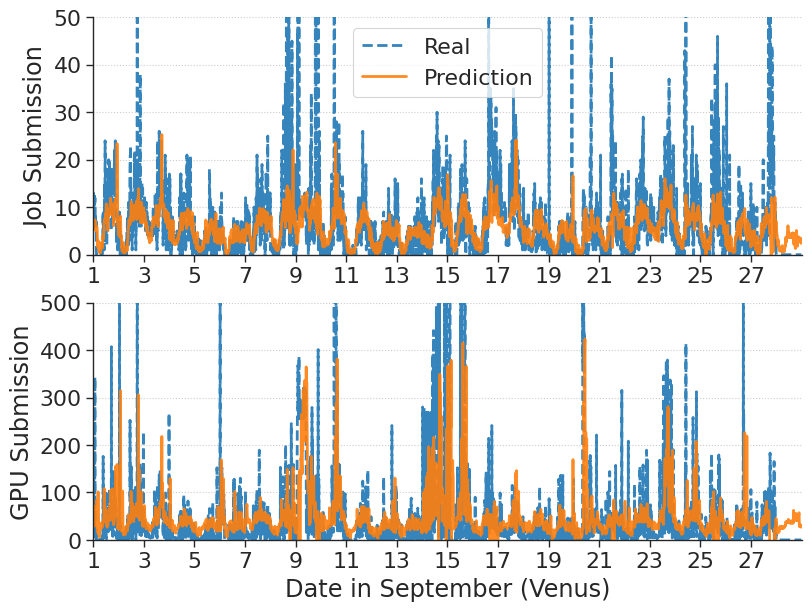

In [5]:
def plot_predict_all(df, cluster, ymax_job, ymax_gpu, save=False):
    fig, (ax1, ax2) = plt.subplots(
        ncols=1, nrows=2, constrained_layout=True, figsize=(8, 6)
    )
    x = np.arange(len(df))
    df.reset_index()

    if cluster == "Philly":
        str_month = "November"
    else:
        str_month = "September"

    ax1.plot(x, df["submit_gpu_job"], linestyle="--", alpha=0.9, label="Real", linewidth=2)
    ax1.plot(x, df["pred_gpu_job"], linestyle="-", alpha=0.9, label="Prediction", linewidth=2)
    # ax1.set_xlabel(f"Date in {str_month} ({cluster})")
    ax1.set_ylabel("Job Submission")

    tick_interval = 2 * 144  # Two days
    ax1.set_xticks(x[::tick_interval])
    ax1.set_xticklabels(df.index.day[::tick_interval])
    ax1.set_xlim(0, len(df) + 1)
    ax1.set_ylim(0, ymax_job[cluster])
    ax1.grid(axis="y", linestyle=":")
    ax1.legend()

    ax2.plot(x, df["submit_gpu_num"], linestyle="--", alpha=0.9, label="Real", linewidth=2)
    ax2.plot(x, df["pred_gpu_num"], linestyle="-", alpha=0.9, label="Prediction", linewidth=2)
    ax2.set_xlabel(f"Date in {str_month} ({cluster})")
    ax2.set_ylabel("GPU Submission")

    ax2.set_xticks(x[::tick_interval])
    ax2.set_xticklabels(df.index.day[::tick_interval])
    ax2.set_xlim(0, len(df) + 1)
    ax2.set_ylim(0, ymax_gpu[cluster])
    ax2.grid(axis="y", linestyle=":")

    sns.despine()

    if save:
        fig.savefig(f"./{cluster}_throughput.pdf", bbox_inches="tight")

pred_df = pd.read_csv(f"./{cluster}_throughput_pred.csv", parse_dates=["time"], index_col="time")

plot_predict_all(pred_df, cluster, ymax_job, ymax_gpu, save=True)


# Model Interpretation

In [ ]:
ebm = ebm.prModel.gam
feature_score = ebm.feature_importances_
sorted_score = sorted(feature_score, reverse=True)
sort_idx = sorted(range(len(feature_score)), key= lambda x: feature_score[x],reverse=True)
sorted_feature = [ebm.feature_names[i] for i in sort_idx]

sorted_feature = [i.replace("_ngpu", "") for i in sorted_feature]

In [ ]:
cmp = sns.color_palette("tab10")
cmp1 = sns.color_palette("Blues",8)
def global_interpret(n_features=12, save=False):
    fig, ax = plt.subplots(
        ncols=1, nrows=1, constrained_layout=True, figsize=(5, 4)
    )
    
    n_features = n_features
    x = np.arange(1, n_features+1)

    ax.barh(x[::-1], sorted_score[:n_features], label=sorted_feature[:n_features], height=0.2, color=cmp1[5])
    ax.scatter(sorted_score[:n_features], x[::-1], s=50, color=cmp1[5])
    
    ax.set_xlim(0, 1)
    ax.set_yticks(x)
    ax.set_yticklabels(sorted_feature[:n_features][::-1])
    ax.set_xlabel(f"Average Absolute Score")
    ax.grid(axis="x", linestyle=":")
    sns.despine()

    if save:
        fig.savefig(f"./interpret_{cluster}_throughput.pdf", bbox_inches="tight")


global_interpret(n_features=12, save=True)

In [ ]:
from sklearn.isotonic import IsotonicRegression

feature_index = 2
x = np.array(range(len(ebm.additive_terms_[feature_index])))
y = ebm.additive_terms_[feature_index]
w = ebm.preprocessor_.col_bin_counts_[feature_index]
direction = "auto"
ir = IsotonicRegression(out_of_bounds="clip", increasing=direction)
y_ = ir.fit_transform(x, y, sample_weight=w)

In [ ]:
def hour_interpret(save=False):
    fig, ax = plt.subplots(
        ncols=1, nrows=1, constrained_layout=True, figsize=(5, 4)
    )
    y2 = 0
    ax.plot(x, y, '-', label="Shape Function", marker="X", markersize=8, linewidth=2.5, color=cmp1[5], alpha=1)

    ax.set_xlabel("Hour Bins")
    ax.set_ylabel(f"Score")
    ax.set_xlim(0, 24)
    ax.set_xticks([0, 4, 8, 12, 16, 20, 24])
    # ax.set_ylim(-1.5, 4)
    sns.despine()

    ax.grid(axis="y", linestyle=":")
    ax.axhline(y=0, c=cmp1[-1], linewidth=2)
    ax.fill_between(x, y, y2, facecolor=cmp1[5], alpha = 0.1, hatch='/')
    ax.legend(loc=0, fontsize=16)

    if save:
        fig.savefig(f"./interpret_{cluster}_shapefunc.pdf", bbox_inches="tight")


hour_interpret(save=True)